In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import numpy
import sys
from scipy import stats

restaurants = pd.read_csv('final_restaurants.csv')
restaurants

,Unnamed: 0,lat,lon,amenity,name,tags,address,Code,Place,is chain
0,0,49.260812,-123.125736,cafe,starbucks,"{'brand:wikidata': 'Q37158', 'official_name': ...","1001 W 12th Ave, Vancouver, BC V6H 0A5, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
1,2,49.263582,-123.128836,cafe,waves,{'opening_hours': 'Mo-Fr 06:00-24:00; Sa-Su 08...,"1095 BC-7, Vancouver, BC V6H 0A8, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
2,7,49.263448,-123.138067,fast_food,mcdonald's,"{'brand:wikidata': 'Q38076', 'addr:housenumber...","1482 BC-7, Vancouver, BC V6H 4E8, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
3,9,49.263225,-123.133390,restaurant,denny's,"{'brand:wikidata': 'Q1189695', 'addr:housenumb...","1296 W Broadway, Vancouver, BC V6H 1G6, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
4,10,49.271156,-123.135808,restaurant,the keg,"{'brand:wikidata': 'Q7744066', 'wheelchair': '...","1499 Duranleau St, Vancouver, BC V6H 3S3, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
...,...,...,...,...,...,...,...,...,...,...
5096,5092,49.033067,-123.069255,restaurant,browns socialhouse,{},"1665 56 St, Delta, BC V4L 2B2, Canada",V4L,Delta Southeast,False
5097,5095,49.024524,-123.066485,cafe,wood n frog coffee company,{},"5694 12 Ave, Delta, BC V4L 1C4, Canada",V4L,Delta Southeast,False
5098,5097,49.250815,-123.168022,fast_food,ridge garden,"{'addr:housenumber': '4009', 'phone': '+1-604-...","4017 Macdonald St, Vancouver, BC V6L 2N8, Canada",V6L,Vancouver (NW Arbutus Ridge),False
5099,5098,49.187647,-122.552271,cafe,kanaka creek coffee,{},"24155 102 Ave, Maple Ridge, BC V2W 2C6, Canada",V2W,Maple Ridge East,False


In [2]:
contingency = list()
for code in restaurants['Code'].unique():
    chains = restaurants[restaurants['Code']==code]['is chain'].sum()
    indie = restaurants[restaurants['Code']==code]['is chain'].count() - chains
    if chains != 0 and indie != 0:
        contingency.append([indie, chains])
chi2res = stats.chi2_contingency(contingency)
chi2res[1]
# extremely small p-value, reject that values are independent across categories.

1.4259027842371983e-38

Trying to do ANOVA... but I dont think the data is fit for that...

In [3]:
restaurants = restaurants[['name','amenity','tags','Code','is chain']]
grouped = restaurants.groupby('Code', as_index=False).agg({'is chain': ['sum', 'count']})
grouped.columns = grouped.columns.map('_'.join)
grouped = grouped.reset_index(drop=True)
grouped['mean'] = grouped['is chain_sum'] / grouped['is chain_count']
grouped = grouped[['Code_','mean']]
grouped

,Code_,mean
0,V0M,0.000000
1,V0N,0.000000
2,V1M,0.396825
3,V2R,0.000000
4,V2S,0.369748
...,...,...
97,V7T,0.560000
98,V7V,0.235294
99,V7W,0.350000
100,V7X,0.666667


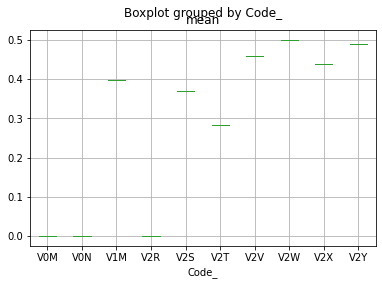

In [4]:
grouped[0:10].boxplot(column='mean', by='Code_')

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

Predicting ratings

In [5]:
ratings = pd.read_csv('hot_encoded_rests.csv')
ratings = ratings[['name','lat','lon','code','price_level','rating','user_ratings_total','bar', 'bistro',
       'cafe', 'fast_food', 'ice_cream', 'juice_bar', 'pub', 'restaurant','chain_False','chain_True']]
ratings.loc[ratings['price_level'].isnull(), ['price_level']] = 0 # Make NaN price levels zero.
ratings

,name,lat,lon,code,price_level,rating,user_ratings_total,bar,bistro,cafe,fast_food,ice_cream,juice_bar,pub,restaurant,chain_False,chain_True
0,starbucks,49.260812,-123.125736,V6H,2.0,3.9,127,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,waves,49.263582,-123.128836,V6H,0.0,3.8,290,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,mcdonald's,49.263448,-123.138067,V6H,1.0,3.4,539,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,denny's,49.263225,-123.133390,V6H,2.0,4.0,532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,the keg,49.271156,-123.135808,V6H,3.0,4.2,1366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096,browns socialhouse,49.033067,-123.069255,V4L,2.0,4.0,348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5097,wood n frog coffee company,49.024524,-123.066485,V4L,1.0,4.6,224,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5098,ridge garden,49.250815,-123.168022,V6L,2.0,4.1,79,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5099,kanaka creek coffee,49.187647,-122.552271,V2W,2.0,4.7,261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
X = ratings.drop(['name','code','rating'], axis=1).to_numpy()
y = ratings['rating']

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

X = np.stack([X_train['lat'], X_train['lon'], X_train['price_level'], X_train['user_ratings_total'],
              X_train['bar'], X_train['bistro'], X_train['cafe'],
              X_train['fast_food'], X_train['ice_cream'], X_train['juice_bar'],
              X_train['pub'], X_train['restaurant'], X_train['chain_False'],
              X_train['chain_True']], axis=1)
model = LinearRegression(fit_intercept=True)
model.fit(X, y_train)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [9]:
X_columns = ['lat','lon','price_level','user_ratings_total','bar','bistro','cafe',
             'fast_food','ice_cream','juice_bar','pub','restaurant','chain_False','chain_True']
coefficients = model.coef_
regress = ' + '.join('%.3g*%s' % (coef, col) for col, coef in zip(X_columns, coefficients))
print('next_temp = ' + regress)

NameError: name 'model' is not defined

In [10]:
print("Training score: %g\nValidation score: %g" % (model.score(X_train, y_train), model.score(X_valid, y_valid)))

NameError: name 'model' is not defined

Predicting price_level

In [11]:
X = ratings.drop(['name','code','price_level'], axis=1).to_numpy()
y = ratings['price_level']
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [12]:
model = RandomForestClassifier(n_estimators=1000, max_depth=20, min_samples_leaf=3)
model.fit(X_train, y_train)
print("Training score: %g\nValidation score: %g" % (model.score(X_train, y_train), model.score(X_valid, y_valid)))

Training score: 0.835556
Validation score: 0.67163
